<a href="https://colab.research.google.com/github/HayeonLee/minimalRL/blob/master/RL_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# REINFORCE
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

#Hyperparameters
learning_rate = 0.0002
gamma         = 0.98

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x
      
    def put_data(self, item):
        self.data.append(item)
        
    def train_net(self):
        R = 0
        for r, log_prob in self.data[::-1]:
            R = r + gamma * R
            loss = -log_prob * R
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.data = []

def main():
    env = gym.make('CartPole-v1')
    pi = Policy()
    score = 0.0
    print_interval = 20
    
    for n_epi in range(10000):
        s = env.reset()
        for t in range(501): # CartPole-v1 forced to terminates at 500 step.
            prob = pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample()
            s_prime, r, done, info = env.step(a.item())
            pi.put_data((r,torch.log(prob[a])))
            
            s = s_prime
            score += r
            if done:
                break

        pi.train_net()
        
        if n_epi % print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {}".format(n_epi, score/print_interval))
            score = 0.0
    env.close()
    
if __name__ == '__main__':
    main()

# of episode :20, avg score : 23.8
# of episode :40, avg score : 26.5
# of episode :60, avg score : 26.25
# of episode :80, avg score : 35.6
# of episode :100, avg score : 45.95
# of episode :120, avg score : 64.15
# of episode :140, avg score : 62.35
# of episode :160, avg score : 65.5
# of episode :180, avg score : 92.3
# of episode :200, avg score : 134.45
# of episode :220, avg score : 146.65
# of episode :240, avg score : 138.25
# of episode :260, avg score : 117.75
# of episode :280, avg score : 227.85
# of episode :300, avg score : 207.75
# of episode :320, avg score : 275.15
# of episode :340, avg score : 313.8
# of episode :360, avg score : 227.7
# of episode :380, avg score : 414.2
# of episode :400, avg score : 264.6
# of episode :420, avg score : 195.0
# of episode :440, avg score : 235.45
# of episode :460, avg score : 243.75
# of episode :480, avg score : 307.7
# of episode :500, avg score : 188.9
# of episode :520, avg score : 207.45
# of episode :540, avg score : 249.55

KeyboardInterrupt: ignored

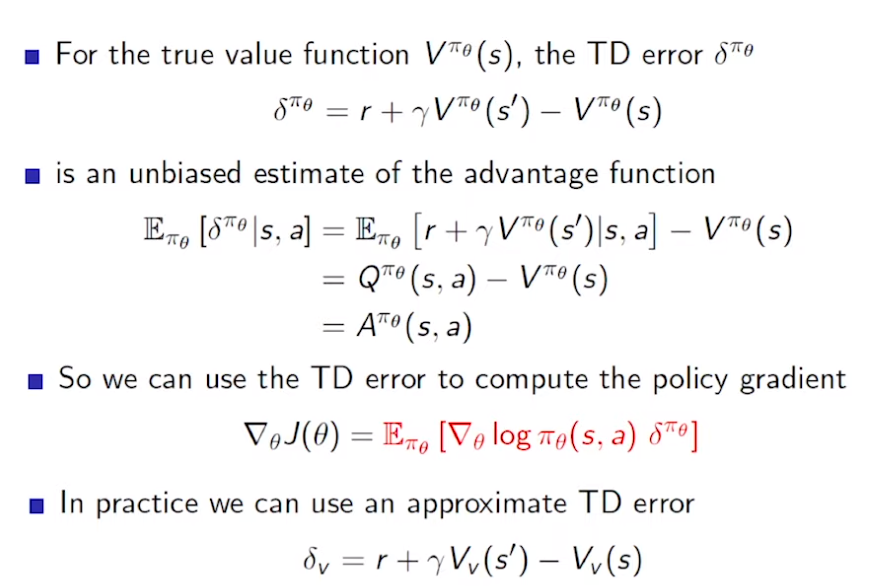

In [0]:
# Actor-Critic
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

#Hyperparameters
learning_rate = 0.0002
gamma         = 0.98

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
    
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []
        for transition in self.data:
            s,a,r,s_prime,done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r/100.0])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_lst.append([done_mask])
        
        s_batch = torch.tensor(s_lst, dtype=torch.float)
        a_batch = torch.tensor(a_lst)
        r_batch = torch.tensor(r_lst, dtype=torch.float)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float)
        done_batch = torch.tensor(done_lst, dtype=torch.float)
        self.data = []
        return s_batch, a_batch, r_batch, s_prime_batch, done_batch
  
    def train_net(self):
        s, a, r, s_prime, done = self.make_batch()
        td_target = r + gamma * self.v(s_prime) * done
        delta = td_target - self.v(s)
        
        pi = self.pi(s, softmax_dim=1)
        pi_a = pi.gather(1,a)
        loss = -torch.log(pi_a) * delta.detach() + \
                  F.smooth_l1_loss(self.v(s), td_target.detach())

        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()         
      
def main():  
    env = gym.make('CartPole-v1')
    model = ActorCritic()    
    n_rollout = 5
    print_interval = 20
    score = 0.0

    for n_epi in range(10000):
        done = False
        s = env.reset()
        while not done:
            for t in range(n_rollout):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, done, info = env.step(a)
                model.put_data((s, a, r, s_prime, done))
                
                s = s_prime
                score += r
                
                if done:
                    break                     
            
            model.train_net()
            
        if n_epi%print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()